In [1]:
import datetime as dt
import polars as pl
import plotly.express as px

from model import XGBoostModel
from config import get_config

In [2]:
target_col = 'fperf'
date_col = 'tdq'

In [3]:
def find_last_trading_date():
    today = dt.datetime.today()
    trade_dates = [
        dt.datetime(today.year - 1, 12, 1),
        dt.datetime(today.year, 3, 1),
        dt.datetime(today.year, 6, 1),
        dt.datetime(today.year, 9, 1),
        dt.datetime(today.year, 12, 1),
    ]
    past_dates = [date for date in trade_dates if date <= today]
    return max(past_dates)

last_trade_date = find_last_trading_date()
last_trade_date

datetime.datetime(2024, 9, 1, 0, 0)

In [4]:
data = pl.read_csv("../data/1_work_data/processed/proc_2024-11-02.csv", try_parse_dates=True)
data.head()

datadate,rdq,tdq,tic,sector_Communication Services,sector_Consumer Discretionary,sector_Consumer Staples,sector_Energy,sector_Financials,sector_Health Care,sector_Industrials,sector_Information Technology,sector_Materials,sector_Real Estate,sector_Utilities,n_purch,n_sales,insider_balance,price_mom,price_qoq,price_yoy,price_2y,rsi_14d,rsi_30d,rsi_60d,rsi_90d,rsi_1y,vol_mom,vol_qoq,vol_yoy,rel_vol_mom,rel_vol_qoq,rel_vol_yoy,momentum_mom,momentum_qoq,momentum_yoy,momentum_2y,…,ltda,ltcr,itr,rtr,atr,cfm,size,earn_drift,pe,pb,ps,ev_ebitda,saleq_yoy,saleq_2y,ni_yoy,ni_2y,ltq_yoy,ltq_2y,dlttq_yoy,gpm_yoy,roa_yoy,roe_yoy,fcf_yoy,cr_yoy,qr_yoy,der_yoy,dr_yoy,ltda_yoy,ev_eb_yoy,ltcr_yoy,pe_yoy,pb_yoy,ps_yoy,freturn,adj_freturn,fperf,adj_fperf
date,date,date,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64
2007-01-31,2007-02-15,2007-03-01,"""A""",0,0,0,0,0,1,0,0,0,0,0,0,1,8.598,-0.0175,-0.018727,-0.126667,0.31,37.080402,42.592688,46.374228,46.439982,50.571208,0.014809,0.012043,0.01791,1.68021,1.931065,2.790708,0.974836,-7.1022,-1.324112,1.869599,…,0.208536,0.037333,2.007843,1.87821,0.1758,0.072656,8.880864,-7.064743,14.209289,2.490608,1.790829,14.053467,0.096829,0.056106,-0.946733,0.456311,-0.080125,0.045535,0.0,0.034773,-0.786032,-0.758874,1.314607,-0.033049,-0.06119,0.051933,0.026403,0.115807,-0.424184,1.314607,2.825606,-0.077548,-0.192082,-2.639948,2.529778,0,0
2007-04-30,2007-05-14,2007-06-01,"""A""",0,0,0,0,0,1,0,0,0,0,0,0,3,2.695,0.052226,0.241648,0.097162,0.594336,62.343397,62.077772,58.732066,58.636249,53.754651,0.016561,0.013553,0.017389,2.953679,2.207784,2.674983,1.932873,2.392662,0.463493,2.053564,…,0.205959,0.173333,2.033898,1.900648,0.182371,0.228788,8.893298,6.59983,16.705873,3.04982,2.098338,15.689363,0.065375,0.032864,0.069565,0.294737,-0.064022,0.096793,0.0,0.058001,-0.764364,-0.756945,0.078838,-0.048932,-0.09261,0.072623,0.035449,0.106275,-0.275697,0.078838,3.789035,0.163999,-0.006303,-2.325005,6.524596,0,0
2007-07-31,2007-08-14,2007-09-01,"""A""",0,0,0,0,0,1,0,0,0,0,0,0,2,5.747,-0.057483,-0.051342,0.1375,0.13679,52.575103,48.65697,49.886609,49.92594,51.861727,0.032772,0.021062,0.01607,2.055281,1.725055,2.02726,-47.276502,1.795475,1.064454,0.622403,…,0.213554,0.093333,2.075529,1.887363,0.192074,0.128093,8.857088,0.192679,16.580932,3.061018,1.89827,14.783464,0.108959,0.10628,-0.185022,0.778846,-0.051054,0.097532,0.0,-0.005011,-0.789586,-0.780068,27.0,-0.13529,-0.202801,0.094405,0.044192,0.10037,-0.142223,27.0,4.723257,0.258728,0.039965,-4.505501,8.463382,0,0
2007-10-31,2007-11-15,2007-12-01,"""A""",0,0,0,0,0,1,0,0,0,0,0,0,2,2.75,0.026594,0.046184,0.180712,0.065934,59.704889,54.609299,52.512775,52.488568,52.118787,0.026217,0.017897,0.016334,1.572782,1.465377,1.689781,-0.603821,7.683146,3.097014,0.3707,…,0.276277,0.172017,2.1959,1.96334,0.198381,0.275242,8.929833,12.255191,15.693153,3.095928,1.847275,14.923904,0.088855,0.027719,0.208054,6.2,0.16442,0.638847,0.391333,-0.01305,-0.800194,-0.782379,-0.057743,-0.142226,-0.198205,0.313484,0.135903,0.357259,-0.051532,-0.322767,4.562228,0.214109,-0.015412,-54.374817,-9.481695,0,0
2008-01-31,2008-02-13,2008-03-01,"""A""",0,0,0,0,0,1,0,0,0,0,0,0,2,3.418,-0.104447,-0.190854,-0.026399,-0.149722,34.6395,38.84194,42.496746,42.578853,48.452257,0.018267,0.018484,0.017808,1.373549,1.408677,1.586141,5.62391,1.878156,0.510655,-3.837171,…,0.083925,-0.047923,2.115414,1.906913,0.185573,0.002872,8.917177,-6.334147,13.252579,2.539416,1.456275,10.717445,0.088281,0.193659,-0.2,-0.957386,0.212104,0.114984,-0.582667,0.009526,-0.079976,0.093202,-1.535714,-0.306119,-0.280077,0.396995,0.168878,-0.597549,-0.237381,-2.28366,-0.06733,0.019597,-0.186815,-54.68801,-9.931769,0,0


In [ ]:
features = get_config('model')['features']
df = data.select(
    [pl.col("fperf")] + [pl.col(ratio) for ratio in features]
).to_pandas()

In [5]:
df_standardized = ((df[features] - df[features].mean()) / df[features].std())
corr = df_standardized.corrwith(df['fperf'])
corr_df = pl.DataFrame({
    'Feature': corr.index,
    'Correlation': corr.values
}).sort('Correlation', descending=False)

fig = px.bar(
    corr_df,
    x='Correlation',
    y='Feature',
    orientation='h',
    title='Feature Correlations with Target (fperf)',
    width=1000,
    height=1200
)
fig.update_layout(
    yaxis={'tickfont': {'size': 10}},
    showlegend=False,
    margin=dict(l=200)
)
fig.add_vline(x=0, line_dash="dash", line_color="gray")
fig.show()

In [6]:
data = data.filter(
    (pl.col('tdq') < last_trade_date) &
    (~pl.all_horizontal(pl.col(target_col).is_null()))
)

# filter cols
aux_cols = ['datadate', 'rdq', 'sector'] + [t for t in get_config('model')['targets'] if t != target_col]
data = data.select([c for c in data.columns if c not in aux_cols])
data.head()

tdq,tic,sector_Communication Services,sector_Consumer Discretionary,sector_Consumer Staples,sector_Energy,sector_Financials,sector_Health Care,sector_Industrials,sector_Information Technology,sector_Materials,sector_Real Estate,sector_Utilities,n_purch,n_sales,insider_balance,price_mom,price_qoq,price_yoy,price_2y,rsi_14d,rsi_30d,rsi_60d,rsi_90d,rsi_1y,vol_mom,vol_qoq,vol_yoy,rel_vol_mom,rel_vol_qoq,rel_vol_yoy,momentum_mom,momentum_qoq,momentum_yoy,momentum_2y,gpm,roa,…,dr,der,debitda,ltda,ltcr,itr,rtr,atr,cfm,size,earn_drift,pe,pb,ps,ev_ebitda,saleq_yoy,saleq_2y,ni_yoy,ni_2y,ltq_yoy,ltq_2y,dlttq_yoy,gpm_yoy,roa_yoy,roe_yoy,fcf_yoy,cr_yoy,qr_yoy,der_yoy,dr_yoy,ltda_yoy,ev_eb_yoy,ltcr_yoy,pe_yoy,pb_yoy,ps_yoy,fperf
date,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64
2007-03-01,"""A""",0,0,0,0,0,1,0,0,0,0,0,0,1,8.598,-0.0175,-0.018727,-0.126667,0.31,37.080402,42.592688,46.374228,46.439982,50.571208,0.014809,0.012043,0.01791,1.68021,1.931065,2.790708,0.974836,-7.1022,-1.324112,1.869599,0.578125,0.088037,…,0.491589,0.966913,20.090909,0.208536,0.037333,2.007843,1.87821,0.1758,0.072656,8.880864,-7.064743,14.209289,2.490608,1.790829,14.053467,0.096829,0.056106,-0.946733,0.456311,-0.080125,0.045535,0.0,0.034773,-0.786032,-0.758874,1.314607,-0.033049,-0.06119,0.051933,0.026403,0.115807,-0.424184,1.314607,2.825606,-0.077548,-0.192082,0
2007-06-01,"""A""",0,0,0,0,0,1,0,0,0,0,0,0,3,2.695,0.052226,0.241648,0.097162,0.594336,62.343397,62.077772,58.732066,58.636249,53.754651,0.016561,0.013553,0.017389,2.953679,2.207784,2.674983,1.932873,2.392662,0.463493,2.053564,0.590909,0.089666,…,0.511877,1.048664,19.216495,0.205959,0.173333,2.033898,1.900648,0.182371,0.228788,8.893298,6.59983,16.705873,3.04982,2.098338,15.689363,0.065375,0.032864,0.069565,0.294737,-0.064022,0.096793,0.0,0.058001,-0.764364,-0.756945,0.078838,-0.048932,-0.09261,0.072623,0.035449,0.106275,-0.275697,0.078838,3.789035,0.163999,-0.006303,0
2007-09-01,"""A""",0,0,0,0,0,1,0,0,0,0,0,0,2,5.747,-0.057483,-0.051342,0.1375,0.13679,52.575103,48.65697,49.886609,49.92594,51.861727,0.032772,0.021062,0.01607,2.055281,1.725055,2.02726,-47.276502,1.795475,1.064454,0.622403,0.590247,0.084854,…,0.531891,1.136253,16.17316,0.213554,0.093333,2.075529,1.887363,0.192074,0.128093,8.857088,0.192679,16.580932,3.061018,1.89827,14.783464,0.108959,0.10628,-0.185022,0.778846,-0.051054,0.097532,0.0,-0.005011,-0.789586,-0.780068,27.0,-0.13529,-0.202801,0.094405,0.044192,0.10037,-0.142223,27.0,4.723257,0.258728,0.039965,0
2007-12-01,"""A""",0,0,0,0,0,1,0,0,0,0,0,0,2,2.75,0.026594,0.046184,0.180712,0.065934,59.704889,54.609299,52.512775,52.488568,52.118787,0.026217,0.017897,0.016334,1.572782,1.465377,1.689781,-0.603821,7.683146,3.097014,0.3707,0.577455,0.087529,…,0.571882,1.335807,18.227848,0.276277,0.172017,2.1959,1.96334,0.198381,0.275242,8.929833,12.255191,15.693153,3.095928,1.847275,14.923904,0.088855,0.027719,0.208054,6.2,0.16442,0.638847,0.391333,-0.01305,-0.800194,-0.782379,-0.057743,-0.142226,-0.198205,0.313484,0.135903,0.357259,-0.051532,-0.322767,4.562228,0.214109,-0.015412,0
2008-03-01,"""A""",0,0,0,0,0,1,0,0,0,0,0,0,2,3.418,-0.104447,-0.190854,-0.026399,-0.149722,34.6395,38.84194,42.496746,42.578853,48.452257,0.018267,0.018484,0.017808,1.373549,1.408677,1.586141,5.62391,1.878156,0.510655,-3.837171,0.583632,0.080996,…,0.574608,1.350772,21.867347,0.083925,-0.047923,2.115414,1.906913,0.185573,0.002872,8.917177,-6.334147,13.252579,2.539416,1.456275,10.717445,0.088281,0.193659,-0.2,-0.957386,0.212104,0.114984,-0.582667,0.009526,-0.079976,0.093202,-1.535714,-0.306119,-0.280077,0.396995,0.168878,-0.597549,-0.237381,-2.28366,-0.06733,0.019597,-0.186815,0


In [7]:
train = data.filter(
    (pl.col('tdq').dt.year() > 2007) &
    (pl.col('tdq').dt.year() < 2022)
)
val = data.filter(
    (pl.col('tdq').dt.year() >= 2022) &
    (pl.col('tdq').dt.year() < 2023)
)

def get_scale():
    scale = round(
        len(train.filter(pl.col(target_col) == 0)) /
        len(train.filter(pl.col(target_col) == 1))
    )

    print(f"Scale of training data (pos/neg): {scale}")
    return scale

scale = get_scale()

X_train = train.select(pl.exclude(['tic', target_col, date_col])).to_pandas()
y_train = train.select(target_col).to_pandas().values.ravel()
X_val = val.select(pl.exclude(['tic', target_col, date_col])).to_pandas()
y_val = val.select(target_col).to_pandas().values.ravel()

X_train

Scale of training data (pos/neg): 3


,sector_Communication Services,sector_Consumer Discretionary,sector_Consumer Staples,sector_Energy,sector_Financials,sector_Health Care,sector_Industrials,sector_Information Technology,sector_Materials,sector_Real Estate,...,cr_yoy,qr_yoy,der_yoy,dr_yoy,ltda_yoy,ev_eb_yoy,ltcr_yoy,pe_yoy,pb_yoy,ps_yoy
0,0,0,0,0,0,1,0,0,0,0,...,-0.306119,-0.280077,0.396995,0.168878,-0.597549,-0.237381,-2.283660,-0.067330,0.019597,-0.186815
1,0,0,0,0,0,1,0,0,0,0,...,-0.301765,-0.243269,0.365127,0.150162,-0.606461,-0.243443,1.671284,-0.123835,0.000622,-0.190346
2,0,0,0,0,0,1,0,0,0,0,...,-0.193095,-0.061566,0.203659,0.086017,-0.624940,-0.296361,1.306055,-0.164869,-0.088150,-0.183973
3,0,0,0,0,0,1,0,0,0,0,...,0.096797,0.077685,0.427013,0.146931,0.034227,-0.492541,-0.414559,-0.602664,-0.454568,-0.594871
4,0,0,0,0,0,1,0,0,0,0,...,0.403954,0.227777,0.321975,0.115582,2.583585,-0.339152,0.835314,-0.594239,-0.475344,-0.575958
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33273,0,0,0,0,0,1,0,0,0,0,...,-0.358636,-0.284122,-0.125895,-0.033086,-0.159871,0.160897,0.085747,0.168908,-0.012159,0.250797
33274,0,0,0,0,0,1,0,0,0,0,...,0.158816,0.272363,-0.201131,-0.055762,-0.059228,0.049260,0.112460,0.076636,-0.156173,0.102592
33275,0,0,0,0,0,1,0,0,0,0,...,0.185975,0.350357,-0.255998,-0.075931,-0.076953,0.094265,-0.112482,0.140825,-0.154823,0.135680
33276,0,0,0,0,0,1,0,0,0,0,...,-0.028763,-0.035855,-0.338497,-0.104708,-0.148811,0.072161,0.198462,0.076586,-0.127650,0.087172


In [8]:
len(train.filter(pl.col(target_col) == 0)) / len(train.filter(pl.col(target_col) == 1))

3.4988508854941194

In [9]:
from sklearn.feature_selection import RFE
from xgboost import XGBClassifier
import sklearn.metrics as skm

params = {
    'objective': 'binary:logistic',
    'learning_rate': 0.1,
    'n_estimators': 100,
    'max_depth': 3,
    'min_child_weight': 1,
    'gamma': 0,
    'subsample': 1,
    'colsample_bytree': 1,
    'reg_alpha': 0,
    'reg_lambda': 1,
    'scale_pos_weight': scale,
    'eval_metric': 'logloss',
    'nthread': -1,
    'seed': get_config('model')['seed']
}

rbf_model = XGBClassifier(**params)

# Use RFE to rank feature importance and eliminate unuseful features
selector = RFE(rbf_model, n_features_to_select=20)
selector = selector.fit(X_train, y_train)

support = selector.support_
ranking = selector.ranking_

rbf_model.fit(X_train, y_train)
init_probs = rbf_model.predict_proba(X_val)[:, 1]
print("Model roc-auc with initial features:", skm.roc_auc_score(y_val, init_probs))
print("Model pr-auc with initial features:", skm.average_precision_score(y_val, init_probs))

selected_features = X_train.columns[support]
print("Selected Features:", selected_features)

X_train_selected = X_train[selected_features]
X_val_selected = X_val[selected_features]
rbf_model.fit(X_train_selected, y_train)

sel_probs = rbf_model.predict_proba(X_val_selected)[:, 1]
print("Model roc-auc with selected features:", skm.roc_auc_score(y_val, sel_probs))
print("Model pr-auc with selected features:", skm.average_precision_score(y_val, sel_probs))

Model roc-auc with initial features: 0.7446194670280036
Model pr-auc with initial features: 0.21628897004757794
Selected Features: Index(['sector_Information Technology', 'sector_Utilities', 'price_mom',
       'price_2y', 'rsi_1y', 'vol_mom', 'vol_qoq', 'vol_yoy', 'rel_vol_qoq',
       'rel_vol_yoy', 'momentum_mom', 'momentum_qoq', 'momentum_2y', 'cr',
       'csr', 'atr', 'size', 'pb', 'ps', 'ev_eb_yoy'],
      dtype='object')
Model roc-auc with selected features: 0.7552186841312858
Model pr-auc with selected features: 0.21755519109719068


In [10]:
model = XGBoostModel(scale=scale)
model.train(X_train, y_train)
model.evaluate(X_val, y_val)['roc_auc']

np.float64(0.7446194670280036)

In [11]:
model.evaluate(X_val, y_val)['prec']

np.float64(0.2653061224489796)

In [12]:
baseline = float(
    len(val.filter(pl.col(target_col) == 1)) /
    len(val)
)

pr_auc = model.evaluate(X_val, y_val)['pr_auc']
pr_auc

print(f"Baseline {baseline}, PR-AUC = {pr_auc}")

Baseline 0.10224438902743142, PR-AUC = 0.21628897004757794


In [13]:
model.get_importance("weight")

[('momentum_2y', 52.0),
 ('vol_yoy', 46.0),
 ('size', 45.0),
 ('price_2y', 28.0),
 ('ps', 26.0),
 ('vol_qoq', 25.0),
 ('rel_vol_yoy', 25.0),
 ('atr', 24.0),
 ('momentum_mom', 21.0),
 ('csr', 20.0),
 ('momentum_yoy', 19.0),
 ('rel_vol_qoq', 18.0),
 ('ltcr', 18.0),
 ('rtr', 18.0),
 ('gpm', 16.0),
 ('sector_Utilities', 14.0),
 ('momentum_qoq', 14.0),
 ('dr', 14.0),
 ('pb', 14.0),
 ('price_mom', 13.0),
 ('roa', 13.0),
 ('ev_eb_yoy', 12.0),
 ('price_qoq', 11.0),
 ('roe', 10.0),
 ('pe', 10.0),
 ('vol_mom', 9.0),
 ('ps_yoy', 9.0),
 ('itr', 8.0),
 ('rsi_14d', 7.0),
 ('rsi_1y', 7.0),
 ('dr_yoy', 7.0),
 ('ltda_yoy', 7.0),
 ('cr', 6.0),
 ('sector_Communication Services', 5.0),
 ('price_yoy', 5.0),
 ('rsi_60d', 5.0),
 ('rel_vol_mom', 5.0),
 ('qr', 5.0),
 ('earn_drift', 5.0),
 ('ev_ebitda', 5.0),
 ('saleq_2y', 5.0),
 ('ltq_2y', 5.0),
 ('dlttq_yoy', 5.0),
 ('der_yoy', 5.0),
 ('sector_Information Technology', 4.0),
 ('ltda', 4.0),
 ('gpm_yoy', 4.0),
 ('qr_yoy', 4.0),
 ('sector_Consumer Staples', 3.0)

In [14]:
model.get_importance("gain")

[('vol_yoy', 668.2801513671875),
 ('vol_mom', 238.8883514404297),
 ('vol_qoq', 232.72837829589844),
 ('price_mom', 111.4688720703125),
 ('sector_Utilities', 111.16339111328125),
 ('size', 108.20530700683594),
 ('atr', 103.23871612548828),
 ('sector_Information Technology', 94.90618896484375),
 ('csr', 91.00992584228516),
 ('price_2y', 90.44414520263672),
 ('rel_vol_yoy', 78.79985046386719),
 ('momentum_2y', 77.00160217285156),
 ('cr', 76.1431655883789),
 ('rsi_90d', 71.05437469482422),
 ('ps', 68.59455108642578),
 ('dr_yoy', 64.55858612060547),
 ('rsi_1y', 62.936004638671875),
 ('rel_vol_qoq', 62.02825164794922),
 ('pb', 61.78389358520508),
 ('ltq_2y', 59.83052444458008),
 ('qr_yoy', 59.41650390625),
 ('momentum_mom', 55.42319869995117),
 ('ev_eb_yoy', 53.45625686645508),
 ('momentum_yoy', 50.16633605957031),
 ('rtr', 49.969215393066406),
 ('gpm', 49.494422912597656),
 ('price_qoq', 47.407596588134766),
 ('momentum_qoq', 47.208797454833984),
 ('price_yoy', 46.89986038208008),
 ('roa_yo

In [15]:
model.get_importance("weight")

[('momentum_2y', 52.0),
 ('vol_yoy', 46.0),
 ('size', 45.0),
 ('price_2y', 28.0),
 ('ps', 26.0),
 ('vol_qoq', 25.0),
 ('rel_vol_yoy', 25.0),
 ('atr', 24.0),
 ('momentum_mom', 21.0),
 ('csr', 20.0),
 ('momentum_yoy', 19.0),
 ('rel_vol_qoq', 18.0),
 ('ltcr', 18.0),
 ('rtr', 18.0),
 ('gpm', 16.0),
 ('sector_Utilities', 14.0),
 ('momentum_qoq', 14.0),
 ('dr', 14.0),
 ('pb', 14.0),
 ('price_mom', 13.0),
 ('roa', 13.0),
 ('ev_eb_yoy', 12.0),
 ('price_qoq', 11.0),
 ('roe', 10.0),
 ('pe', 10.0),
 ('vol_mom', 9.0),
 ('ps_yoy', 9.0),
 ('itr', 8.0),
 ('rsi_14d', 7.0),
 ('rsi_1y', 7.0),
 ('dr_yoy', 7.0),
 ('ltda_yoy', 7.0),
 ('cr', 6.0),
 ('sector_Communication Services', 5.0),
 ('price_yoy', 5.0),
 ('rsi_60d', 5.0),
 ('rel_vol_mom', 5.0),
 ('qr', 5.0),
 ('earn_drift', 5.0),
 ('ev_ebitda', 5.0),
 ('saleq_2y', 5.0),
 ('ltq_2y', 5.0),
 ('dlttq_yoy', 5.0),
 ('der_yoy', 5.0),
 ('sector_Information Technology', 4.0),
 ('ltda', 4.0),
 ('gpm_yoy', 4.0),
 ('qr_yoy', 4.0),
 ('sector_Consumer Staples', 3.0)

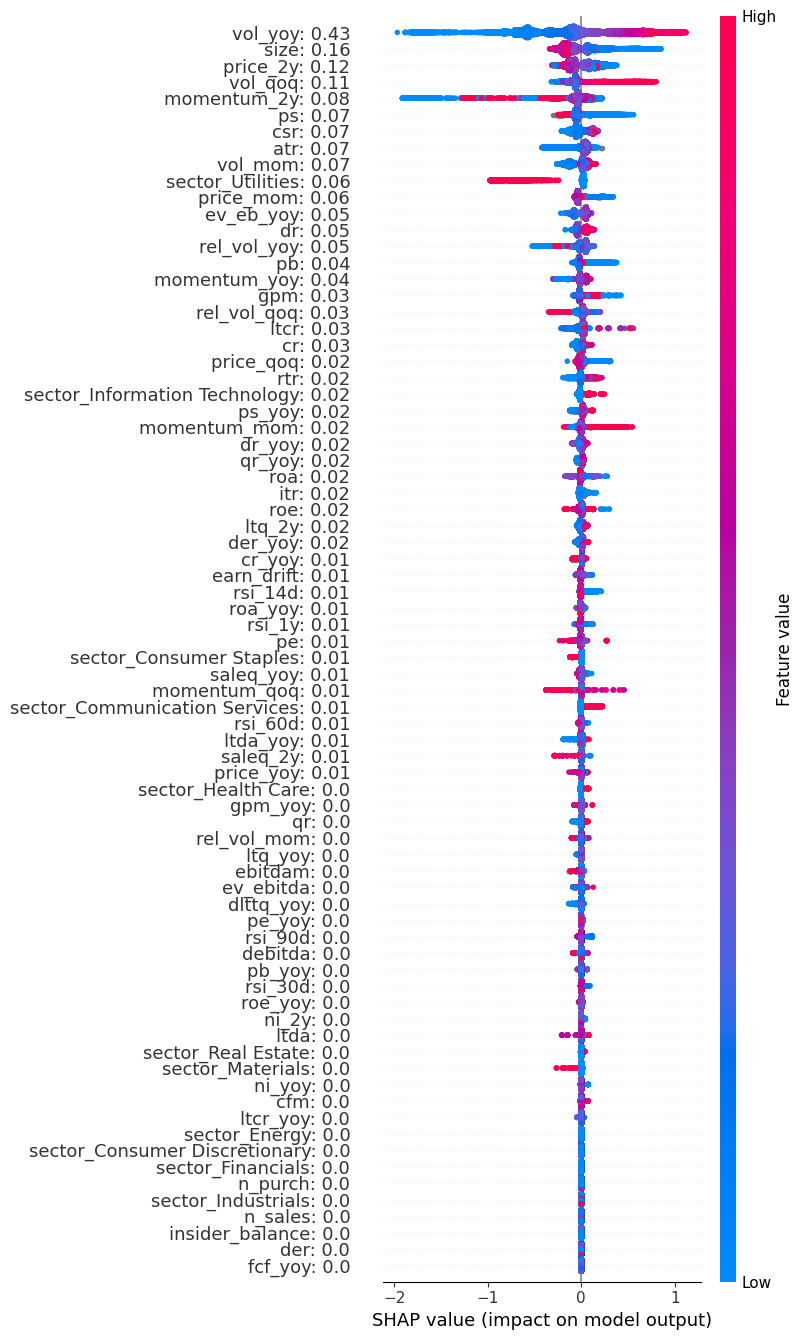

In [16]:
import shap
import numpy as np

explainer = shap.TreeExplainer(model.model)
shap_values = explainer(X_train)

feature_names = [
    a + ": " + str(b) for a,b in zip(X_train.columns, np.abs(shap_values.values).mean(0).round(2))
]

shap.summary_plot(
    shap_values,
    X_train,
    max_display=X_train.shape[1],
    feature_names=feature_names,
    plot_size=(8, 13.5)
)